Copyright 2024 Google LLC.
SPDX-License-Identifier: Apache-2.0

# AI Advatars
Use AI to evaluate an advertising creative against the most likely buyer personas.  This colab walks yout hrough the step by step process so you can get ideas, customize them, and build your own client specific avatars.

1. Configure Gemini Ai to drive the avatars.
1. Star with a product description.
1. Gemini will find the best avatars to evaluate.
1. Reliably move the avatars into Python structures.
1. Use each avatar to:
  * Evaluate an existing image creative to get edit suggestions.
  * Prioratize personas to invest in custom campaigns.
  * Get user journey insights into the persona.
  * Create an audience targeting plan for each persona.
  * Generate keyword lists.
  * Create an effective landing page template for each avatar.
1. Create summary sheet of each avatar for your campaign.

This is advertising specific toolkit to get you started with AI and advertising creatives. Key concepts you can leverage in your day to day are:

1. Examples of advertising prompts.
1. Practical means of moving data from AI to Python for processing.
1. Using Gemini for text and for images in tandem.
1. Building a data strucutre that can be fed into a Google Ads Product.

Every step in this workbook builds on the last, so if you modify a step, remember to re-run the next steps in the sequence. To help you tune the prompts each step is designed to be run as many times as you need to get the output to where you like it.  Although you can use this workbook without editing code, the prompts are intended to be customized and evolved to your product and needs. Feel free to edit:
* **Prompts** to adjust fields and content.
* **Data Structures** to add or remove avatars for example.
* **Models** the Gemini Text model is better at text, use Gemini Vision only for images.
* **Sections** to add entirely new data for each avatar.

# Setting Expectations
1. This is an AI integration, things may format incorrectly, try re-running a step if it errors on parsing.
2. To see output you may need to expand the cells.

## Setup

### Install Vertex AI SDK

In [1]:
!pip install google-cloud-aiplatform --upgrade --user --quiet

**Colab only**: Uncomment the following cell to restart the kernel or use the restart button. For Vertex AI Workbench you can restart the terminal using the button on top.

In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticating your notebook environment
If you are using Colab to run this notebook, uncomment the cell below and continue.
If you are using Vertex AI Workbench, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [3]:
from google.colab import auth

auth.authenticate_user()

### Set your Project ID & Initialize Vertex AI SDK
If you don't know your project ID, you may be able to get your project ID using `gcloud`. Otherwise, check the support page: Locate the [project ID](https://support.google.com/googleapi/answer/7014113). Please update `PROJECT_ID` below.

In [24]:
# Define project information
PROJECT_ID = "gtech-kenjora"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

Import Libraries

In [25]:
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image, Part

# AI Advatars

In [26]:
#@title Add Product Description To Get Avatars
#@markdown This product description will be used to build your avatars.

product = "mazda 3 hatchback" # @param {type:"string"}


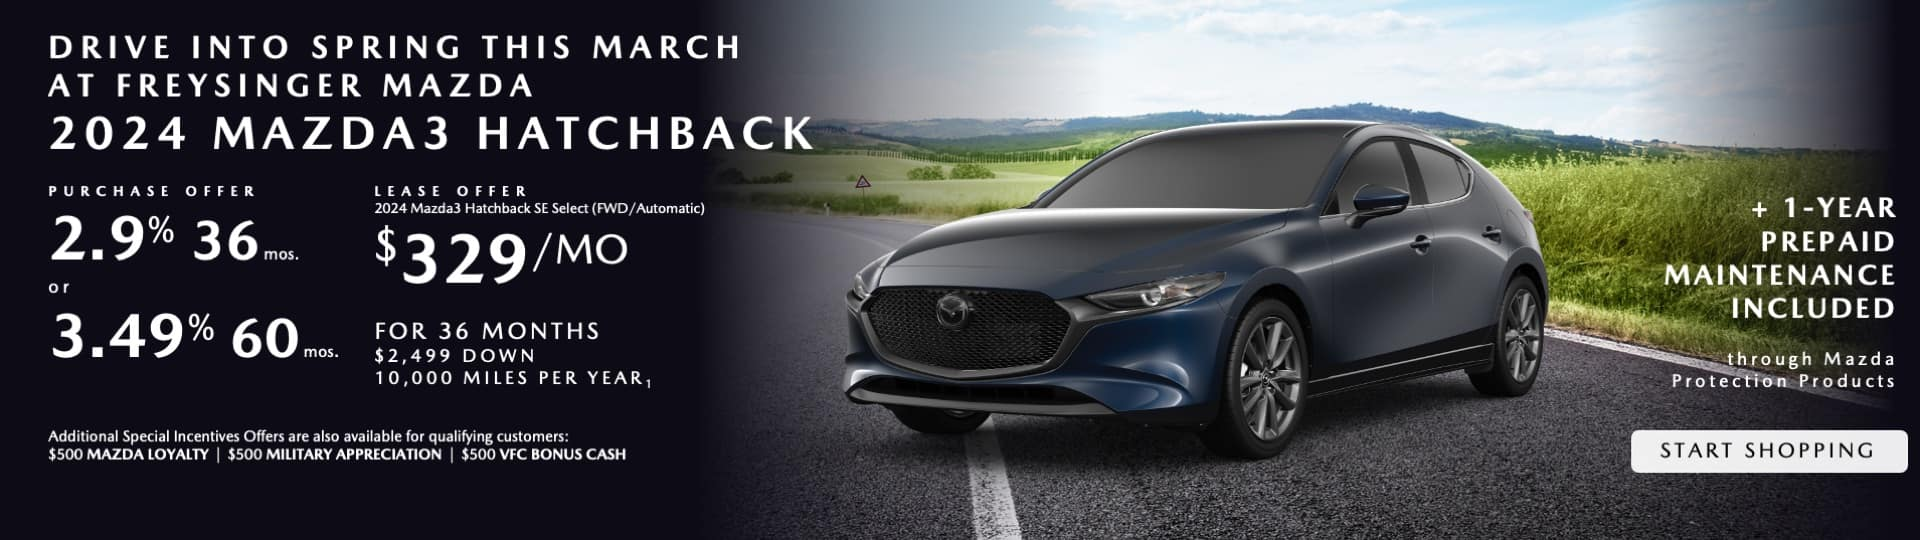

In [7]:
#@title Add An Existing Creative To Evaluate Against Avatars
#@markdown This image will be evaluated by the avatars.
#@markdown Click on the folder icon on the left and upload an image, then paste the path here.

from base64 import b64encode
from IPython.display import HTML, Markdown
from PIL import Image as PIL_Image

def embed_image(path_to_image):
  try:
    img = open(path_to_image, 'rb').read()
    return 'data:image/jpeg;base64,' + b64encode(img).decode()
  except FileNotFoundError:
    return ''

picture_url = '/content/creative.jpg' # @param {type:"string"}

try:
  picture = PIL_Image.open(picture_url)
except OSError:
  picture = None
  print('WARNING: No uploaded creative detected, some parts of this workbook may not work.')

HTML(f'<img src="{embed_image(picture_url)}" width="100%"/>')

In [35]:
#@title Set Up Imports And Helpers Plus Initialize Chat
#@markdown This just sets up common workbook functions and imports necessary libraries.

import re
import json
from IPython.display import HTML, Markdown

RE_LIST = re.compile(r'\[.*\]', re.DOTALL)
RE_DICT = re.compile(r'{.*}', re.DOTALL)
RE_HTML = re.compile(r'<.*>', re.DOTALL)

def response_to_list(response):
  return json.loads(RE_LIST.search(response.text).group(0))

def response_to_dict(response):
  try:
    return json.loads(RE_DICT.search(response.text).group(0))
  except json.JSONDecodeError:
    print('Parse JSON Error:', response.text)

def response_to_html(response):
  return RE_HTML.search(response.text).group(0)

model_vision = GenerativeModel("gemini-1.0-pro-vision")
#model_vision = genai.GenerativeModel('gemini-pro-vision')
model_text = GenerativeModel("gemini-1.0-pro")
#model_text = genai.GenerativeModel('gemini-pro')
chat = model_text.start_chat(history=[])

#STEP 1: Get A List Of AI Recommended Avatars
The output will be a PYTHON object, if you get errors try adjusting the product description.


In [36]:
prompt = f'Imagine you\'re an agency directory running an advertising campaign for the {product}, provide descriptive persona names and explanations of why each is a fit.'
response = chat.send_message(f'Format the response as JSON list with two keys: persona, description.\n\n{prompt}')

avatars = response_to_list(response)
history = chat.history

print(json.dumps(avatars, indent=2))

[
  {
    "persona": "The Eco-Conscious Adventurer",
    "description": "This persona embodies individuals who prioritize sustainability and an active lifestyle. The Mazda 3 hatchback aligns perfectly with their values, offering exceptional fuel efficiency, a sleek design, and ample cargo space for outdoor gear. They appreciate the hatchback's versatility for both city commutes and weekend getaways, making it an ideal companion for their adventures."
  },
  {
    "persona": "The Tech-Savvy Urbanite",
    "description": "This persona represents city dwellers who embrace technology and seek a stylish and sophisticated vehicle. The Mazda 3 hatchback caters to their needs with its advanced infotainment system, intuitive controls, and sleek design. Its compact size and maneuverability make it a perfect fit for navigating busy urban streets, while its premium features provide a luxurious driving experience."
  },
  {
    "persona": "The Design Enthusiast",
    "description": "This persona en

#STEP 2: Evaluate The Creative Against Each Avatar
The output will be added to your existing PYTHON object, if you get errors try adjusting the product description.

In [29]:
if picture is None:
  print('Go back and upload an image to the colab, then run the creative step again.')
else:
  target_picture = Image.load_from_file(picture_url)
  for avatar in avatars:
    print('Running:', avatar['persona'])
    prompt = f'Imagine you\'re a display marketing expert, evaluate the attached image against the persona {avatar["persona"]}, {avatar["description"]}. List things to keep, change, and suggest three ideal advertising images for {avatar["persona"]}:'
    response = model_vision.generate_content(
      contents=[f'Format your response as JSON dictionary with the keys: keep, change, sample.\n\n{prompt}', target_picture]
    )
    avatar['edits'] = response_to_dict(response)

print(json.dumps(avatars, indent=2))

Running: The Eco-Conscious Commuter
Running: The Thrill-Seeking Adventurer
Running: The Tech-Savvy Urbanite
Running: The Style-Conscious Individual
Running: The Value-Seeking Buyer
[
  {
    "persona": "The Eco-Conscious Commuter",
    "description": "This persona prioritizes fuel efficiency and environmental responsibility. They live in a urban or suburban area with access to public transportation, but still enjoy the convenience and flexibility of owning a car. They are interested in the Mazda 3 hatchback's impressive fuel economy, low emissions, and sleek, modern design.",
    "edits": {
      "keep": [
        "The image is clean and easy to read.",
        "The headline is clear and concise.",
        "The body copy is informative and highlights the key features of the car.",
        "The call to action is clear and easy to follow."
      ],
      "change": [
        "The image could be more visually appealing.",
        "The headline could be more attention-grabbing.",
        "T

#STEP 3: Rank The Avatars Based On Product Fit
This demonstrates how to use the personas in a single prompt to generate a ranked list. This creates a new object.

In [30]:
table = '\n'.join(f'{avatar["persona"]}: {avatar["description"]}' for avatar in avatars)
prompt = f'Of the following personas, which one is most and least likley to purchase after seeing the attached advetisement, and why:\n\n{table}'
response = model_vision.generate_content(
  contents=[f'Format your response as JSON dictionary with three keys: most, least, reason.\n\n{prompt}', target_picture]
)
fit = response_to_dict(response)
print(json.dumps(fit, indent=2))

{
  "most": "Value-Seeking Buyer",
  "least": "Eco-Conscious Commuter",
  "reason": "The Value-Seeking Buyer is looking for a car that offers a lot of value for the price. They are impressed by the Mazda 3 hatchback's competitive pricing, its long list of standard features, and its excellent fuel economy. They believe that the hatchback offers a great balance of price, performance, and features.\n\nThe Eco-Conscious Commuter prioritizes fuel efficiency and environmental responsibility. They are interested in the Mazda 3 hatchback's impressive fuel economy and low emissions, but they may be less interested in the car's performance and features. They may also be concerned about the hatchback's price."
}


#Step 4: Get Audience Suggestions For Each Avatar
Let Gemini determine which method of targeting is the best fit for each avatar.

In [39]:
methods = [
  {
    "title": "Floodlight Targeting",
    "description": "Tracks user behavior across web, app, and ads using Google Marketing Platform's conversion tracking pixel to create tag-based audiences."
  },
  {
    "title": "Activity-based Targeting",
    "description": "Creates audiences based on campaign interactions or excludes users based on impression counts."
  },
  {
    "title": "YouTube User List Targeting",
    "description": "Creates YouTube remarketing lists based on interactions with your videos, ads, or channel."
  },
  {
    "title": "Customer Match Targeting",
    "description": "Uploads customer CSV for targeting (minimum audience size of 1,000 users)."
  },
  {
    "title": "Google Analytics 360 Audience Targeting",
    "description": "Shares GA360 remarketing lists based on site/app behavior for targeting or building similar audiences."
  },
  {
    "title": "Demographics Targeting",
    "description": "Sets up ad targeting based on demographics like gender, age, parental status, and household income."
  },
  {
    "title": "Affinity Targeting",
    "description": "Targets users with a demonstrated interest in a specific topic."
  },
  {
    "title": "In-market Targeting",
    "description": "Targets users actively researching or comparing related products and services."
  },
  {
    "title": "Custom Audience Targeting",
    "description": "Reaches audiences based on keywords, URLs, and apps related to your product or service."
  },
  {
    "title": "Life Events Targeting",
    "description": "Reaches audiences during key life events like moving, graduating, getting married, or having a baby."
  },
  {
    "title": "Geography Targeting",
    "description": "Targets by region (states, cities, postcodes), or specific locations (business chains, POIs, street addresses, coordinates)."
  },
  {
    "title": "Day and Time Targeting",
    "description": "Specifies serving ads by days and times in user or advertiser timezones."
  },
  {
    "title": "Similar Audiences",
    "description": "Expands existing audiences by targeting users with similar behavior and interests."
  },
  {
    "title": "Third-party (DMP) Audiences",
    "description": "Syncs audiences from third-party Data Management Platforms (DMPs) for more granular targeting."
  }
]

table = '\n'.join(f'{method["title"]}: {method["description"]}' for method in methods)

for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  prompt = f'Pretend you are a marketing expert, you are selling {product} to persona {avatar["persona"]}. Pick 5 audiences that will generate the most sales from the following JSON list of dictionaries:\n\n{table}'
  response = chat.send_message(
    f'Format your response as a JSON formatted list of dictionaries with quoted keys: title, description.\n\n{prompt}'
  )
  avatar['targeting'] = response_to_list(response)
  print(json.dumps(avatar['targeting'], indent=2))

Running: The Eco-Conscious Adventurer
[
  {
    "title": "Outdoor Gear and Apparel Website Visitors",
    "description": "Target users who frequently visit websites and online retailers specializing in outdoor gear, apparel, and equipment. This audience aligns perfectly with the Mazda 3 hatchback's ability to accommodate various outdoor activities and their need to transport gear conveniently."
  },
  {
    "title": "Social Media Followers of Environmental Organizations",
    "description": "Connect with users who follow and engage with the social media accounts of prominent environmental organizations, such as Greenpeace or the Sierra Club. These individuals are passionate about sustainability and reducing their carbon footprint, making the Mazda 3's fuel efficiency and commitment to eco-friendliness highly appealing to them."
  },
  {
    "title": "Outdoor Adventure Blog Readers and Subscribers",
    "description": "Reach individuals who actively read and follow blogs dedicated to ou

# Step 5: Add Positive And Negative Keywords
The keywords are focused on the product and avatart combination.

In [44]:
for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  avatar['keywords'] = {'positive':[], 'negative':[]}

  # positive
  prompt = f'I\'m running a search engine campaign to sell a {product}. My target audience is {avatar["persona"]}. Can you suggest 20 audience specific keywords? Avoid the product name in the keywords.'
  response = chat.send_message(
    f'Format your response as a JSON list of dictionaries with the keys: keyword, match.\n\n{prompt}'
  )
  avatar['keywords']['positive'] = response_to_list(response)

  # negative
  prompt = f'I\'m running a search engine campaign to sell a {product}. My target audience is {avatar["persona"]}. Can you suggest 20 audience specific negative keywords to avoid? Avoid the product name in the keywords.'
  response = chat.send_message(
    f'Format your response as a JSON list of dictionaries with the keys: keyword:value, match:value.\n\n{prompt}'
  )
  avatar['keywords']['negative'] = response_to_list(response)
  print(json.dumps(avatar['keywords'], indent=2))

Running: The Eco-Conscious Adventurer
```json
[
  {
    "keyword": "gas guzzler",
    "match": "phrase"
  },
  {
    "keyword": "fuel-inefficient car",
    "match": "broad"
  },
  {
    "keyword": "low gas mileage",
    "match": "phrase"
  },
  {
    "keyword": "bad for the environment",
    "match": "broad"
  },
  {
    "keyword": "polluting car",
    "match": "phrase"
  },
  {
    "keyword": "not eco-friendly",
    "match": "broad"
  },
  {
    "keyword": "high emissions",
    "match": "phrase"
  },
  {
    "keyword": "not sustainable",
    "match": "broad"
  },
  {
    "keyword": "luxury car",
    "match": "phrase"
  },
  {
    "keyword": "expensive car",
    "match": "broad"
  },
  {
    "keyword": "high maintenance car",
    "match": "phrase"
  },
  {
    "keyword": "unreliable car",
    "match": "broad"
  },
  {
    "keyword": "sporty car",
    "match": "phrase"
  },
  {
    "keyword": "fast car",
    "match": "broad"
  },
  {
    "keyword": "high performance car",
    "match": "

#STEP 6: Deep Funnel Analysis
Use the AI to get deep funnel insights such as objections that could be adressed by the creative or the landing page.

In [45]:
for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  prompt = f'Pretend you are {avatar["persona"]}. What is the most likely question you will ask about the {product} shown in the attached image.'
  response = model_vision.generate_content(
    contents=[f'Format your response as a plain text question without quotes.\n\n{prompt}', target_picture]
  )
  avatar['question'] = response.text.strip()

  prompt = f'What response would a good sales person give to {avatar["persona"]} asking a qestion about {product}. The question is:\n\n {avatar["question"]}'
  response = chat.send_message(
    f'Format your response as a plain text sentence without quotes.\n\n{prompt}'
  )
  avatar['response'] = response.text.strip()
  print(avatar['question'])
  print(avatar['response'])

Running: The Eco-Conscious Adventurer
What is the fuel efficiency of the 2024 Mazda 3 hatchback?
"The 2024 Mazda 3 offers excellent fuel efficiency, averaging an estimated 32 mpg in the city and 40 mpg on the highway. For the adventurous soul, this means fewer fuel stops on your road trips and a smaller environmental footprint. Is there anything else you'd like to know about the 3's fuel efficiency or other eco-friendly features?"
Running: The Tech-Savvy Urbanite
What is the fuel efficiency of the 2024 Mazda 3 hatchback?
"The 2024 Mazda 3 hatchback boasts impressive fuel efficiency, achieving an estimated 32 mpg in the city and 40 mpg on the highway. It also features a suite of cutting-edge technologies, including a seamlessly integrated infotainment system and connected car services, keeping you informed and entertained whether you're navigating busy city streets or open roads. Can I answer any other questions about the 3's tech features or fuel efficiency?"
Running: The Design Enthus

# Step 7: Generate A Landing Page For Each Avatar
This is usually done with additional barnd inputs and a template but we can rely on Ai to get us close.  You can use the JSON to feed into an existing template.

In [46]:
for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  prompt = f'Give me an example of a highly converting landing page for {avatar["persona"]} who want to buy a {product}.  The landing page should include: Hero Section, Benefits, Social Proof, Features List, Address Objection With Response, and Call To Action. The objection to address is: {avatar["question"]}. The response is: {avatar["response"]}. Rephrase the obection to be more engaging to the persona.'
  response = chat.send_message(
    f'Format your response as a JSON dictionary.\n\n{prompt}'
  )
  avatar['page'] = response_to_dict(response)
  print(json.dumps(avatar['page'], indent=2))

Running: The Eco-Conscious Adventurer
{
  "Hero Section": {
    "heading": "Embrace Adventure Sustainably",
    "subheading": "Introducing the 2024 Mazda 3 Hatchback: Your Eco-Friendly Companion for Every Exploration",
    "image": "https://www.mazdausa.com/static/images/models/mazda3/2024/hatchback/gallery/hero/2024_mazda3_hatchback_hero_1.jpg",
    "description": "Where will your thirst for adventure take you? Whether it's exploring hidden trails or embarking on a weekend getaway, the 2024 Mazda 3 Hatchback is your reliable and sustainable partner. Experience the thrill of the open road while making a positive impact on the environment."
  },
  "Benefits": {
    "heading": "Why Choose the Mazda 3 Hatchback as Your Eco-Conscious Adventurer?",
    "list": [
      "Fuel Efficiency: Estimated 32 mpg in the city and 40 mpg on the highway, meaning fewer fuel stops and a smaller carbon footprint.",
      "Skyactiv-G Technology: Optimized for both performance and efficiency, delivering a res

# Step 8: Generate A List Of YouTube Channels
Help optimize targeting for this persona on YouTube.

In [47]:
for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  prompt = f'Give me a list of YouTube Channels that are relevant to {product} and are likely to be watched by {avatar["persona"]}.'
  response = chat.send_message(
    f'Format your response as a JSON list of dictionary with keys: channel, description.\n\n{prompt}'
  )
  avatar['youtube'] = response_to_list(response)
  print(json.dumps(avatar['youtube'], indent=2))

Running: The Eco-Conscious Adventurer
[
  {
    "channel": "The Adventure Van",
    "description": "This channel features a young couple living full-time in a converted van, traveling to various locations while being mindful of their impact on the environment. They often showcase fuel-efficient vehicles like the Mazda 3 hatchback as part of their sustainable travel setup."
  },
  {
    "channel": "Eco-Friendly Family Adventures",
    "description": "A family of four documents their adventures exploring national parks and natural wonders, focusing on eco-friendly practices. They frequently highlight fuel-efficient vehicles like the Mazda 3 hatchback as a way to reduce their carbon footprint during road trips."
  },
  {
    "channel": "Green Explorers",
    "description": "This channel focuses on sustainable travel and responsible outdoor recreation, providing tips, gear reviews, and destination recommendations. They often include fuel-efficient vehicles like the Mazda 3 hatchback in the

# Step 9: Generate A List Of CTV Networks
Help optimize targeting for this persona on CTV.

In [ ]:
prompt = 'Please give me a list of Ad-Supported Video on Demand (AVOD) services where I can advertise using Google DV360 or Google Ads.'
response = chat.send_message(
  f'Format your response as a JSON list of dictionary with keys: title, url, description.\n\n{prompt}'
)

channels = response_to_list(response)
print(channels)

table = '\n'.join(f'{channel["title"]}: {channel["description"]}' for channel in channels)

for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  ctv = []
  for channel in channels:
    prompt = f'For each of the listed advertising channels, add a likelyhood scale of LOW, MEDIUM, HIGH and a reason column, indicating the likelyhood the channel has an audience of {avatar["persona"]} interested in {product}:\n\n{table}'
    response = chat.send_message(
      f'Format your response as a JSON list of dictionary with keys: likelyhood, title, description, reason.\n\n{prompt}'
    )
  avatar['ctv'] = response_to_list(response)
  print(json.dumps(avatar['ctv'], indent=2))

#STEP 10: Format The Analysis For Humans
Quickly get something you can copy and paste into a document or an email. Per persona prompt improves the odds the results are not truncated.  This can also be hard coded into a template since we have the JSON structure.

In [ ]:
markdown = ''

for avatar in avatars:
  print('Running:', avatar['persona'])

  # preserve tokens reset history
  chat._history = history

  prompt = f'Please convert the following JSON into nested Markdown:\n {json.dumps(avatar)}'
  response = chat.send_message(prompt)
  avatar['markdown'] = response.text
  markdown += response.text + '\n'

Markdown(markdown)

# Step 11: Export Raw JSON Avatars
Sometimes you just want the raw data...

In [ ]:
print(json.dumps(avatars, indent=2))
print(json.dumps(fit, indent=2))

# Next Steps

Hopefully this demonstrates how Gemini AI can be used to construct a set of advertising avatars and build out trafficking assets such as:
* **Product Personas** - around which to construct campaigns.
* **Creative Feedback** - to improve the click through rate.
* **Audience Methods** - to optimize budget investment.
* **Keyword Optimization** - to improve ROI.
* **Overcoming Objections** - discover and overcome conversion obstacles.
* **Generating Landing Pages** - create a consistent landing page template.

From here you can take several actions:
1. **Write To Database** - leverage BigQuery to store these avatars for future use or bulk analysis.
2. **Email Your Team** - Send each part of the analysis to the creative and landing page teams for editing.
3. **Create Avatar Specific Campaigns** - With some adjustments the JSOn data structures could be used to call the APIs.
4. **Add Image Generation** - Make creatives and landing page assets for each Avatar.

# Questions

Please contact **kenjora@google.com** with edits or bugs in this notebook.

